In [395]:
import numpy as np

#Example done in class using Rule of Mixture and HT Method
#Data given:
S3 = 0.2
S12 = 1
WFibre = 0.6 #Fibre weight Fraction
thickness = 0.000125 #m For each Layer (Question 5)

# Laminate Configuration for Question 1
laminate_config = [90, 45,-45, 0] # (Question 5)
nLayers = len(laminate_config)

print(f'\nThe laminate configuration for this laminate is: {laminate_config}')
print(f'The thickness of the laminate is: {nLayers*thickness} m or {nLayers*thickness*1e3} mm, each laminate in the configuration has the same thickness, thus: {thickness} m')

# Calculating the bottom and top thickness of the laminate
position = [-nLayers * thickness / 2 + i * thickness for i in range(nLayers + 1)]

# Creating an empty list to store Qbar, A1, B1, D1 matrices for each angle
Qbar_list = []
T_list = []
A1_list = []
B1_list = []
D1_list = []

# Use a loop to keep track of the current layer
for i in range(nLayers):  
    angle = laminate_config[i] # Changing index/angle for every loop iteration
    theta = angle * (np.pi / 180)  # Calculate theta based on the angle converted 

    # Question 5 - Material Properties
    E1 = 54 #GPa
    E2 = 18 #GPa
    v12 = 0.28
    v21 = v12 *(E2/E1)  # Minor Poisson Ration
    G12 = 6 #GPa
    
    # Qmatrix
    Q11 = E1 / (1 - v12 * v21)
    Q22 = E2 / (1 - v12 * v21)
    Q12 = v12 * E2 / (1 - v12 * v21)
    Q66 = G12
    Q = np.array([[Q11, Q12, 0],
                [Q12, Q22, 0],
                [0, 0, Q66]])
    # Q = np.round(Q, 3)
    # print(f'\n Q in GN/m^2: \n{Q}')

    # Tmatrix
    T11 = np.cos(theta) ** 2
    T12 = np.sin(theta) ** 2
    T13 = 2 * np.sin(theta) * np.cos(theta)
    T21 = np.sin(theta) ** 2
    T22 = np.cos(theta) ** 2
    T23 = -2 * np.sin(theta) * np.cos(theta)
    T31 = -np.sin(theta) * np.cos(theta)
    T32 = np.sin(theta) * np.cos(theta)
    T33 = np.cos(theta) ** 2 - np.sin(theta) ** 2

    T = np.array([[T11, T12, T13],
                [T21, T22, T23],
                [T31, T32, T33]]) 
    T_list.append(T)
    
    # Inverse of T matrix
    T_inv = np.linalg.inv(T)

    # Transpose of the inverse matrix
    T_inv_transpose = np.transpose(T_inv)

    # Qbar Matrix calculate dot product with T_Inv, Q, T_inv_transpose
    Qbar = T_inv @ Q @ T_inv_transpose*1e9
    Qbar = np.round(Qbar, 3)

    # Converting the NumPy array to a regular Python list
    # Qbar_list.append(Qbar.tolist())
    Qbar_list.append(Qbar)

    # A Matrix
    A1 = Qbar * (position[i + 1] - position[i])
    A1_list.append(A1)

    # B Matrix    
    B1 = (1/2)*Qbar * ((position[i + 1]**2) - (position[i]**2))
    B1_list.append(B1)
    
    # D Matrix    
    D1 = (1/3)*Qbar * ((position[i + 1]**3) - (position[i]**3))
    D1_list.append(D1)

# Set numpy print options to display numbers without scientific notation, NOT ROUNDING
np.set_printoptions(suppress=True, formatter={'float': lambda x: '0' if x == 0.0 else '{:0.6f}'.format(x)})

    
# Defining one single A, B, D matrix for the laminate (through summing A, B, D for each lamina)
A = np.sum(A1_list, axis=0)
B = np.sum(B1_list, axis=0)
D = np.sum(D1_list, axis=0)
# A = np.sum(A1_list, axis=0)/1e9 # To get values in GN/m
# B = np.sum(B1_list, axis=0)/1e9 # To get values in GN
# D = np.sum(D1_list, axis=0)/1e9 # To get values in GN*m

# Concatenating the A, B, and D matrices in the specified order
ABBD = np.block([[A, B], [B, D]])

# Inverse of ABBD Matrix
ABBD_inv = np.linalg.inv(ABBD) 

# Define the different directions
directions = ["Ex", "Ey", "Gxy"]
directions = ["Ex"]
print("\nEngineering Properties:")
for direction in directions:
    NM = [0] * 6     # Initialize the NM Matrix
    
    if direction == "Ex":
        NM[0] = 25000
    elif direction == "Ey":
        NM[1] = 1
    elif direction == "Gxy":
        NM[2] = 1

    NM = np.array(NM).reshape(6, 1)

    result = np.dot(ABBD_inv, NM) # Calculate the strain in different directions -> [ϵx, ϵy, γxy, κx, κy, κxy] vector
    # print(result)

    ex, ey, yxy, kx, ky, kxy = result # Assigning each strain to its value in the result matrix

    if direction == "Ex":
        Sx = ((A[0, 0] * ex + A[0, 1] * ey + A[0, 2] * yxy + B[0, 0] * kx + B[0, 1] * ky + B[0, 2] * kxy)) / (nLayers * thickness)
        Ex = Sx / ex
        print(f"Ex: {Ex*1e-9} GN/m^2")
    elif direction == "Ey":
        Sy = ((A[1, 0] * ex + A[1, 1] * ey + A[1, 2] * yxy + B[1, 0] * kx + B[1, 1] * ky + B[1, 2] * kxy)) / (nLayers * thickness)
        Ey = Sy / ey
        print(f"Ey: {Ey} N/m^2")
    elif direction == "Gxy":
        Sxy = ((A[2, 0] * ex + A[2, 1] * ey + A[2, 2] * yxy + B[2, 0] * kx + B[2, 1] * ky + B[2, 2] * kxy)) / (nLayers * thickness)
        Gxy = Sxy / yxy
        print(f"Gxy: {Gxy} N/m^2 \n")
        
print(result)


The laminate configuration for this laminate is: [90, 45, -45, 0]
The thickness of the laminate is: 0.0005 m or 0.5 mm, each laminate in the configuration has the same thickness, thus: 0.000125 m

Engineering Properties:
Ex: [24.393283] GN/m^2
[[0.002050]
 [-0.000665]
 [-0.000144]
 [-4.690456]
 [-0.763085]
 [2.651645]]


[[0.002050]
 [-0.000665]
 [-0.000144]]
[[-4.690456]
 [-0.763085]
 [2.651645]]


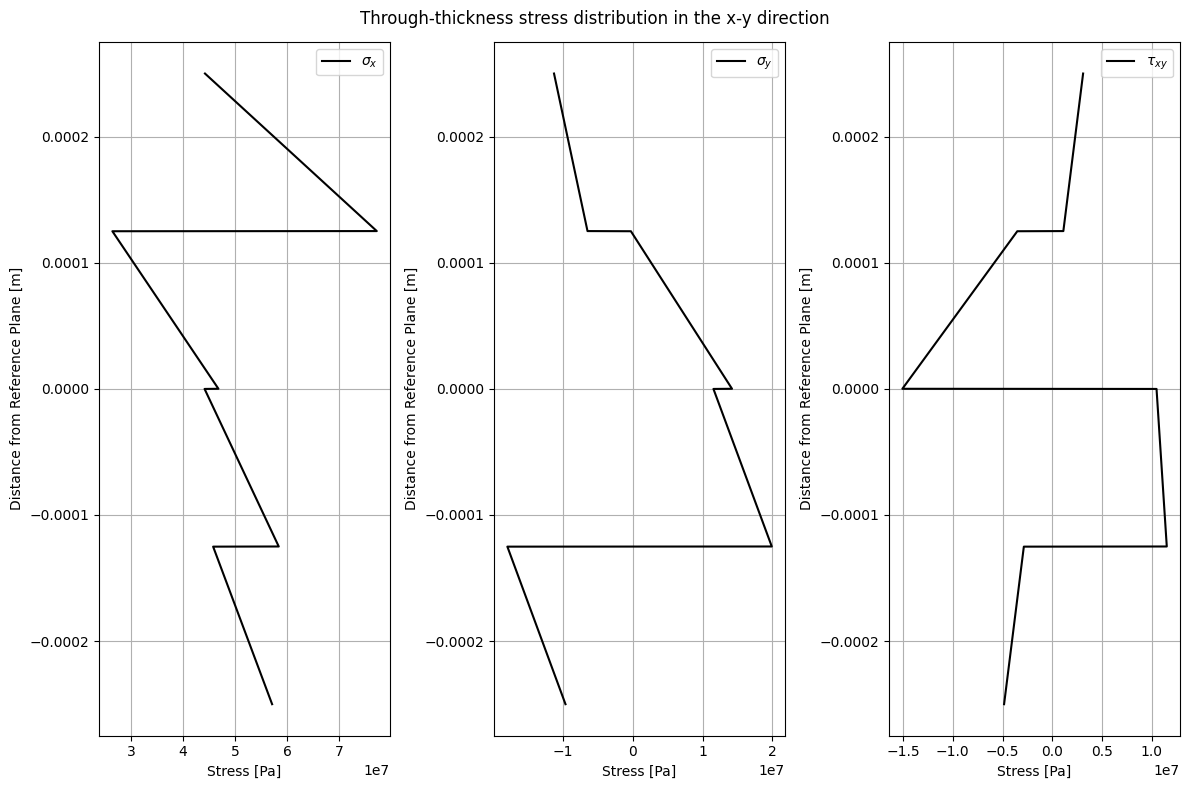

In [396]:
# Calculations for Stress Plots (x-y coordinates)
# Split strains and curvatures
e_o = np.array([ex, ey, yxy]) # Strain
k_o = np.array([kx, ky, kxy]) # Curvature 
print(e_o)
print(k_o)

sigmax = [] # Storing Stresses in the X direction
sigmay = [] # Storing Stresses in the Y direction
tauxy = [] # Storing Stresses in the XY direction

divisions = 1e3

for i in range(nLayers):  # Loop through each ply
    for k in np.arange(0, thickness, position[-2]/divisions):
        z = position[i] + k
        strain = e_o + z * k_o
        temp_stress = np.dot(Qbar_list[i], strain)  # [z[i] + k]*[Qbar]
        sigmax.append(temp_stress[0])
        sigmay.append(temp_stress[1])
        tauxy.append(temp_stress[2])
        
distance = np.linspace(position[0], position[-1], len(sigmax))

#Plotting the Graph
fig, axs = plt.subplots(1, 3, figsize=(12, 8))
fig.suptitle('Through-thickness stress distribution in the x-y direction')
axs[0].plot(sigmax, distance, label=r'$\sigma_{x}$', color='black')
axs[1].plot(sigmay, distance, label=r'$\sigma_{y}$', color='black')
axs[2].plot(tauxy, distance, label=r'$\tau_{xy}$', color='black')
for ax in axs.flat:
    ax.grid(True)
    ax.set_xlabel('Stress [Pa]')
    ax.set_ylabel('Distance from Reference Plane [m]')
    ax.legend()
    
plt.tight_layout()
plt.show()

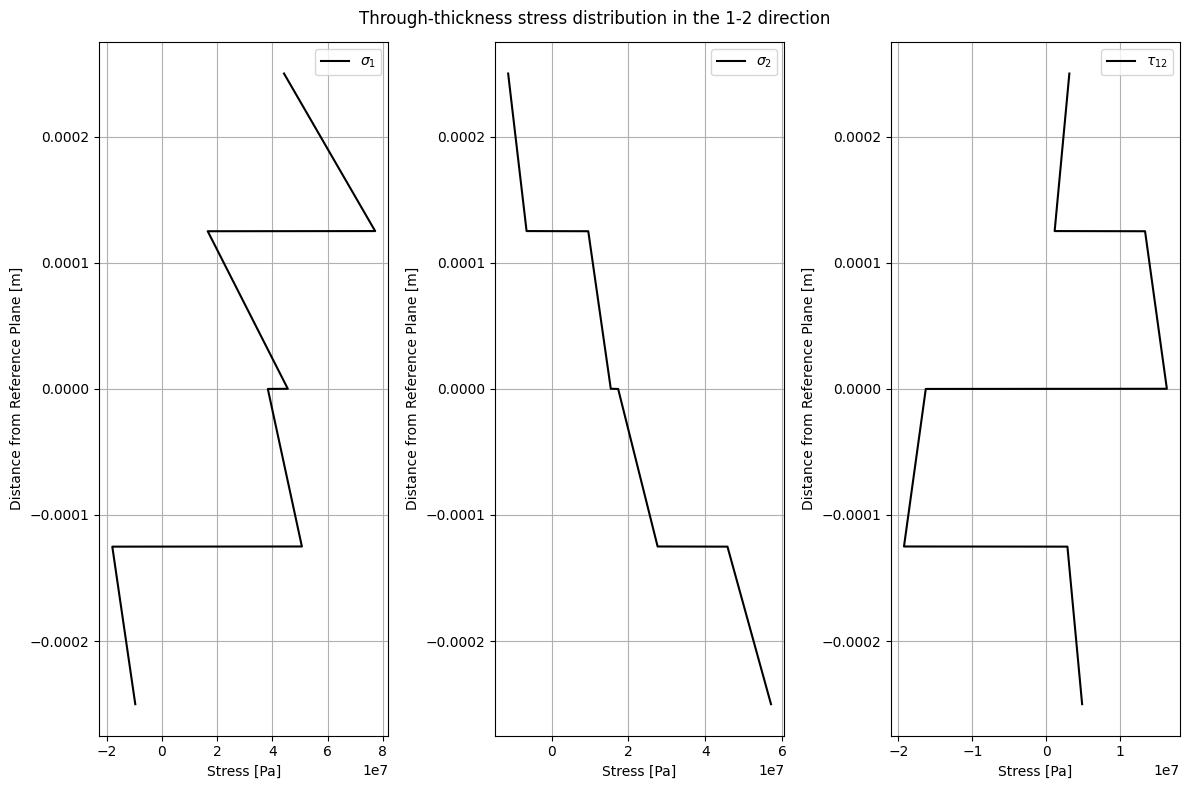

In [397]:
#Stresses List in 1-2 Direction
sigma1 = []
sigma2 = []
tau12 = [] 
eps1 = []
eps2 = []
gamma12 = [] 

for i in range(len(laminate_config)):  # Loop through each ply
    for k in np.arange(0, position[-2], position[-2]/divisions):
        z = position[i] + k
        strain = e_o + z * k_o
        temp_stress = np.dot(Qbar_list[i], strain)  # [z[i] + k]*[Qbar]
        strain12 = np.dot(T_list[i], strain)
        
        eps1.append(strain12[0])
        eps2.append(strain12[1])
        gamma12.append(strain12[2])
        
        transformed_stress = np.dot(T_list[i], temp_stress)    # Temporary stress transformed back to 12 coordinates
        sigma1.append(transformed_stress[0])
        sigma2.append(transformed_stress[1])
        tau12.append(transformed_stress[2])

#Plotting the Graph
fig, axs = plt.subplots(1, 3, figsize=(12, 8))
fig.suptitle('Through-thickness stress distribution in the 1-2 direction')
axs[0].plot(sigma1, distance, label=r'$\sigma_{1}$', color='black')
axs[1].plot(sigma2, distance, label=r'$\sigma_{2}$', color='black')
axs[2].plot(tau12, distance, label=r'$\tau_{12}$', color='black')
for ax in axs.flat:
    ax.grid(True)
    ax.set_xlabel('Stress [Pa]')
    ax.set_ylabel('Distance from Reference Plane [m]')
    ax.legend()
    
plt.tight_layout()
plt.show()

In [398]:
Xt = 1040*1e6 #GPa longitudinal strength in tension
Yt = 35*1e6 #GPa longitudinal strength in compression
Xc = 570*1e6 #GPa transverse strength in tension
Yc = 114*1e6 #GPa transverse strength in compression
S = 72*1e6 #GPa shear strength
eps1t = 0.021
eps2t = 0.002
eps1c = 0.011
eps2c = 0.0064
gamma6 = 0.038

fibreLayer = [0, divisions, divisions+1, (2*divisions)+1, (2*divisions)+2, (3*divisions)+2, (3*divisions)+3, (4*divisions)+3] # [0, 1000, 1001, 2001, 2002, 3002, 3003, 4003]

s1 = [sigma1[int(i)] for i in fibreLayer] # [sigma1[0], sigma1[1000], sigma1[1001], sigma1[2001], sigma1[2002], sigma1[3002], sigma1[3003], sigma1[4003]]
s2 = [sigma2[int(i)] for i in fibreLayer]
t12 = [tau12[int(i)] for i in fibreLayer]
e1 = [eps1[int(i)] for i in fibreLayer]
e2 = [eps2[int(i)] for i in fibreLayer]
g12 = [gamma12[int(i)] for i in fibreLayer]

# Max Stress
print('Max Strain Method')
for i in range(len(s1)):
    if abs(s1[i]) >= Xt:
        print('The laminate failed in parallel tension at ply interface', i)
        safety_factor = Xt/abs(s1[i])
        failure_load = safety_factor*NM[0]
        print(f'The failure load is {failure_load}, N/m')
        break
    elif abs(s2[i]) >= Yt:
        print('The laminate failed in transverse tension at ply interface', i)
        safety_factor = Yt/abs(s2[i])
        failure_load = safety_factor*NM[0]
        print(f'The failure load is {failure_load}, N/m')
        break
    elif abs(s1[i]) <= Xc:
        print(f'The laminate failed in Parallel compression at ply interface', i)
        safety_factor = Xc/abs(s1[i])
        failure_load = safety_factor*NM[0]
        print(f'The failure load is {failure_load}, N/m')
        break
    elif abs(s2[i]) <= Yc:
        print('The laminate failed in transverse compression at ply interface', i)
        safety_factor = Yc/abs(s2[i])
        failure_load = safety_factor*NM[0]
        print(f'The failure load is {failure_load}, N/m')
        break
    elif abs(t12[i]) >= S:
        print('The laminate failed in transverse compression at ply interface', i)
        safety_factor = S/abs(t12[i])
        failure_load = safety_factor*NM[0]
        print(f'The failure load is {failure_load}, N/m')
        break
    else:
        print('The laminate did not fail')



Max Strain Method
The laminate failed in transverse tension at ply interface 0
The failure load is [15323.332909], N/m


In [402]:
print('Max Strain Method')
for i in range(len(e1)):
    
    if abs(e1[i]) >= eps1t:
        print('The laminate failed in parallel tension at ply interface', i)
        safety_factor = eps1t/abs(e1[i])
        failure_load = safety_factor*NM[0]
        print('The failure load is', failure_load, 'N/m')
        break
    elif abs(e2[i]) >= eps2t:
        print('The laminate failed in transverse tension at ply interface', i)
        safety_factor = eps2t/abs(e2[i])
        failure_load = safety_factor*NM[0]
        print('The failure load is', failure_load, 'N/m')
        break
    elif abs(e1[i]) <= eps1c:
        print('The laminate failed in Parallel compression at ply interface', i)
        safety_factor = eps1c/abs(e1[i])
        failure_load = safety_factor*NM[0]
        print('The failure load is', failure_load, 'N/m')
        break
    elif abs(e2[i]) <= eps2c:
        print('The laminate failed in transverse compression at ply interface', i)
        safety_factor = eps2c/abs(e2[i])
        failure_load = safety_factor*NM[0]
        print('The failure load is', failure_load, 'N/m')
        break
    elif abs(g12[i]) >= gamma6:
        print('The laminate failed in transverse compression at ply interface', i)
        safety_factor = gamma6/abs(g12[i])
        failure_load = safety_factor*NM[0]
        print('The failure load is', failure_load, 'N/m')
        break
    else:
        print('The laminate did not fail')

Max Strain Method
The laminate failed in transverse tension at ply interface 0
The failure load is [15516.584427] N/m


In [411]:
# Tsai-Wu Method
F1 = 1/Xt - 1/(Xc)
F2 = 1/Yt - 1/(Yc)
F6 = 0
F11 = 1/(Xt*(Xc))
F22 = 1/(Yt*(Yc))
F66 = 1/(S**2)
F12_star = -0.5
F12 = F12_star * ((F11 * F22) ** (1/2))

print('Tsai-Wu Method')
# print(F1, F2, F6, F11, F22, F66, F12)

for i in range(len(s1)):
    TWS = F1*s1[i] + F2*s2[i] + F11*(s1[i]**2) + F22*(s2[i]**2) + F66*(t12[i]**2) + 2*F12*s1[i]*s2[i]
    if TWS >= 1:
        print('The laminate failed at ply interface', i)
        safety_factor = 1/TWS
        failure_load = safety_factor*NM[0]
        print('The failure load is', failure_load, 'N/m')
        break

Tsai-Wu Method
The laminate failed at ply interface 0
The failure load is [12680.958037] N/m
